In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

In [72]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy



# create a palette dictionary that has the same keys as the original palette
palette = cc.glasbey_hv
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [9]:
import datasets

In [10]:
ds = datasets.load_from_disk('../Data/DataV1/features.arrow')
df = datasets.arrow_dataset.Dataset.to_pandas(ds)

In [11]:
df

,sex,age,dag,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,...,CD-ventricular_tachycardia_or___2,CD-ventricular_tachycardia_or___3,CD-ventricular_tachycardia_or___4,CD-weight_kgs,SUBST-1,SUBST-2,SUBST-3,SUBST-4,SUBST-5,LC_STATUS
0,2.0,30.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,LC_POS
1,1.0,33.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,79.0,0.0,0.0,NaN,0.0,0.0,LC_POS
2,2.0,36.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,55.0,0.0,0.0,NaN,0.0,0.0,LC_POS
3,2.0,50.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,67.0,1.0,0.0,NaN,0.0,0.0,LC_POS
4,1.0,40.0,2,0,0,0,0,0,0,0,...,0.0,0.0,0.0,136.0,0.0,0.0,NaN,0.0,0.0,LC_POS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,1.0,27.0,5,0,0,0,0,0,0,0,...,0.0,0.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,HC
5798,1.0,25.0,1,1,0,0,0,1,0,0,...,NaN,NaN,NaN,95.0,0.0,0.0,0.0,1.0,0.0,LC_POS
5799,2.0,44.0,1,0,0,0,0,1,0,0,...,NaN,NaN,NaN,82.0,0.0,0.0,0.0,0.0,0.0,LC_POS
5800,2.0,51.0,1,1,0,0,0,0,0,0,...,NaN,NaN,NaN,72.0,0.0,0.0,0.0,0.0,0.0,LC_POS


In [12]:
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
                }

# Cleanup

In [13]:
df = df.drop(["SUBST-2", "SUBST-3", "SUBST-4"],axis=1)

In [14]:
cols = df.columns.to_list()

In [15]:
lMeds = [x for x in cols if 'MED-' in x]

In [16]:
lSYMPT = [x for x in cols if 'SYMPT-' in x]

In [17]:
lVAX = [x for x in cols if 'VAX-' in x]

In [18]:
lHHX = [x for x in cols if 'HHX-' in x and 'HHX-OTHER' not in x]

In [19]:
lHHXOther = [x for x in cols if  'HHX-OTHER' in x]

In [20]:
lLABS = [x for x in cols if  'LABS-' in x]

In [21]:
lCD = [x for x in cols if  'CD-' in x]

In [22]:
lSUBST = [x for x in cols if  'SUBST-' in x]

In [23]:
print(df.columns.to_list())

['sex', 'age', 'dag', 'MED-Analgesics', 'MED-Anesthetics', 'MED-Antibacterials', 'MED-Anticonvulsants', 'MED-Antidepressants\xa0', 'MED-Antifungals', 'MED-Antimigraine-agents', 'MED-Antiparasitics', 'MED-Antiparkinson-agents', 'MED-Antipsychotics', 'MED-Antispasticity-agents', 'MED-Antivirals', 'MED-Blood-glucose-regulators', 'MED-Blood-products', 'MED-Cardiovascular-agents', 'MED-Dermatological-agents', 'MED-Gastrointestinal-agents', 'MED-Hormonal-agents-(adrenal)', 'MED-Hormonal-agents-(sex-hormones)', 'MED-Hormonal-agents-(thyroid)', 'MED-Hormone-suppressant-(thyroid)', 'MED-Immunological-agents', 'MED-Inflammatory-bowel-disease-agents', 'MED-Metabolic-bone-disease-agents', 'MED-Ophthalmic-agents', 'MED-Respiratory-tract-agents', 'MED-Skeletal-muscle-relaxants', 'SYMPT-abdominal_pain___1', 'SYMPT-abdominal_pain___2', 'SYMPT-chest_pain___1', 'SYMPT-chest_pain___2', 'SYMPT-confusion_altered_mental_s___1', 'SYMPT-confusion_altered_mental_s___2', 'SYMPT-cough___1', 'SYMPT-cough___2', 'S

In [24]:
df = df.drop(lLABS,axis=1)

In [25]:
dfNA = df[df['dag']<=3] # NORTH AMERICAN SITES - LDN, MTL, SAN

## Drop Cols based on greater than 10% missing

In [20]:
threshold = len(df) * 0.90  # 90% threshold
df.dropna(thresh=threshold, axis=1).dropna()


,sex,age,dag,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,...,HHX-OTHER-resp,HHX-OTHER-sickle-cell-anemia,HHX-OTHER-surgery,HHX-OTHER-ulcerative-colitis,HHX-Obesity,HHX-Other,HHX-Pregnant,SUBST-1,SUBST-5,LC_STATUS
0,2.0,30.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,LC_POS
1,1.0,33.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,LC_POS
2,2.0,36.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,LC_POS
3,2.0,50.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,LC_POS
4,1.0,40.0,2,0,0,0,0,0,0,0,...,0,0,0,0,1.0,1.0,0.0,0.0,0.0,LC_POS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,1.0,27.0,5,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,HC
5798,1.0,25.0,1,1,0,0,0,1,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,LC_POS
5799,2.0,44.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,LC_POS
5800,2.0,51.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,LC_POS


# 1 - Only Complete Patients -- Cant do - no patients with complete data

In [21]:
df.dropna()

,sex,age,dag,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,...,CD-ventilatory_support_type___3,CD-ventilatory_support_type___4,CD-ventricular_tachycardia_or___1,CD-ventricular_tachycardia_or___2,CD-ventricular_tachycardia_or___3,CD-ventricular_tachycardia_or___4,CD-weight_kgs,SUBST-1,SUBST-5,LC_STATUS


# 2 - Drop columns based on treshold complete, keep patients with complete data

In [26]:
def add_suffix_to_dict_keys(dictionary, suffix):
    new_dict = {}
    for key, value in dictionary.items():
        new_key = key + suffix
        new_dict[new_key] = value
    return new_dict

### Tmp - SAMPLE

In [23]:
threshold = len(df) * 0.90  # 90% threshold
df.dropna(thresh=threshold, axis=1).dropna()

,sex,age,dag,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,...,HHX-OTHER-resp,HHX-OTHER-sickle-cell-anemia,HHX-OTHER-surgery,HHX-OTHER-ulcerative-colitis,HHX-Obesity,HHX-Other,HHX-Pregnant,SUBST-1,SUBST-5,LC_STATUS
0,2.0,30.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,LC_POS
1,1.0,33.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,LC_POS
2,2.0,36.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,LC_POS
3,2.0,50.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,LC_POS
4,1.0,40.0,2,0,0,0,0,0,0,0,...,0,0,0,0,1.0,1.0,0.0,0.0,0.0,LC_POS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,1.0,27.0,5,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,HC
5798,1.0,25.0,1,1,0,0,0,1,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,LC_POS
5799,2.0,44.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,LC_POS
5800,2.0,51.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,LC_POS


## Check all column thresholds for ALL Sites

### Calculate DfThres

In [40]:
lThres = []
lLastCols = df.columns.to_list()
for i in range(0, 101, 1):
    threshold = len(df) * (i / 100)
    dfTmp = df.dropna(thresh=threshold, axis=1).dropna()

    dThres = {
        "threshold": i,
        "nCols": len(dfTmp.columns),
        "nPatients": len(dfTmp),
        'colDropped': ','.join(list(set(lLastCols).difference(set(dfTmp.columns.to_list())))),
        'cols': ','.join(dfTmp.columns.to_list())
    }
    lLastCols=dfTmp.columns.to_list()
    dThres.update(dfTmp["LC_STATUS"].value_counts().to_dict())
    dThres.update(
        add_suffix_to_dict_keys(
            (
                dfTmp["LC_STATUS"].value_counts()
                / df["LC_STATUS"].value_counts()
                * 100
            ).to_dict(),
            "_Perc",
        )
    ),
    dThres.update(
        (
            dfTmp["dag"].replace(site_name_dict).value_counts(dropna=False)
            / df["dag"].replace(site_name_dict).value_counts(dropna=False)
            * 100
        ).to_dict()
    )
    lThres.append(dThres)
dfThres = pd.DataFrame(lThres)

In [41]:
dfThres

,threshold,nCols,nPatients,colDropped,cols,HC_Perc,LC_NEG_Perc,LC_POS_Perc,LDN,LUS,MTL,RIO,SAN,LC_NEG,LC_POS,HC
0,0,388,0,,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,383,0,"CD-covid_test_result_5,CD-baby_covid,CD-outcom...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,383,0,,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,382,0,CD-gcs,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,381,0,CD-covid_test_result_4,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,88,5526,,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,94.294479,96.342950,74.294671,95.179905,100.0,84.547739,100.0,3074.0,2371.0,81.0
97,97,74,5647,"SYMPT-fatigue___1,SYMPT-extremity_weakness_or_...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,98.006135,96.342950,74.294671,95.179905,100.0,99.748744,100.0,3195.0,2371.0,81.0
98,98,74,5647,,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,98.006135,96.342950,74.294671,95.179905,100.0,99.748744,100.0,3195.0,2371.0,81.0
99,99,63,5656,"HHX-Arterial Hypertension,SYMPT-nausea_vomitin...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,98.036810,96.668021,77.115987,95.179905,100.0,99.748744,100.0,3196.0,2379.0,81.0


In [42]:
dfThres.to_csv('OUTPUT/MP/02-splicing/2_1-thresholdsAll.csv',index=False)

### Plot

#### Threshold VS nCol and nPatients

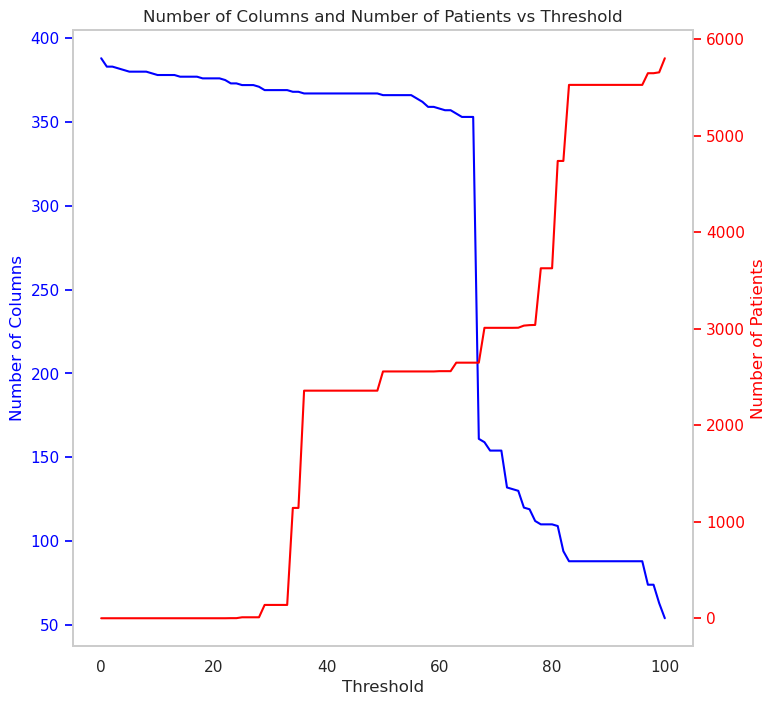

In [27]:
import matplotlib.pyplot as plt

# Extract the data for plotting
x = dfThres['threshold']
y1 = dfThres['nCols']
y2 = dfThres['nPatients']


# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot the first line plot
ax1.plot(x, y1, color='blue')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of Columns', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second line plot
ax2.plot(x, y2, color='red')
ax2.set_ylabel('Number of Patients', color='red')
ax2.tick_params('y', colors='red')

ax1.grid(False)
ax2.grid(False)
# Add a title and legend
plt.title('Number of Columns and Number of Patients vs Threshold')
# plt.legend(['Number of Columns', 'Number of Patients'])

# Display the plot
plt.savefig('OUTPUT/MP/02-splicing/2_1-thresholdsAll.png',dpi=600)
plt.show()

#### Threshold vs nCol and nPatients by LC group

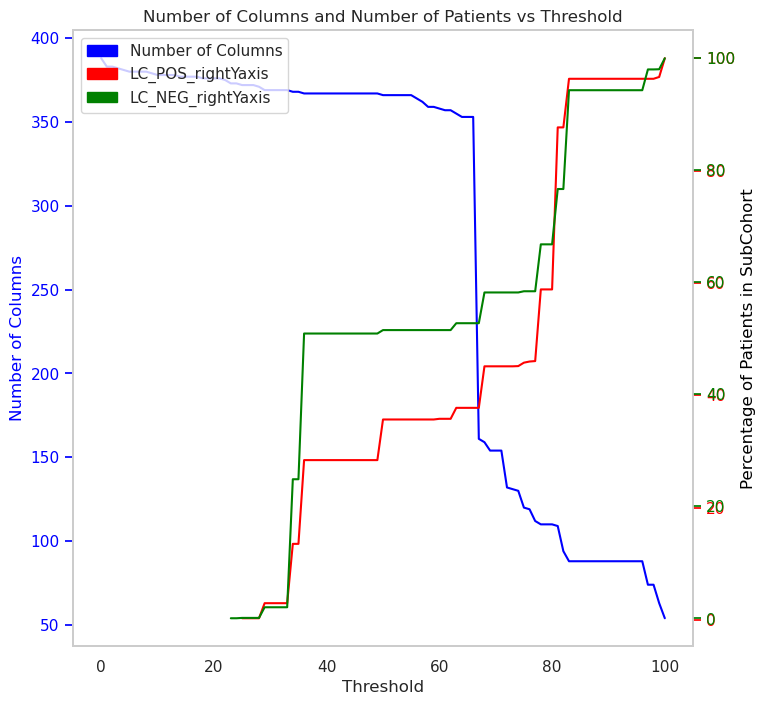

In [56]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Extract the data for plotting
x = dfThres['threshold']
y1 = dfThres['nCols']
y2 = dfThres['LC_POS_Perc']
y3 = dfThres['LC_NEG_Perc']

# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot the first line plot
ax1.plot(x, y1, color='blue',label='num of col')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of Columns', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second line plot
ax2.plot(x, y2, color="red", label="LC_POS_rightYaxis")
ax2.set_ylabel('Percentage of Patients in SubCohort', color='black')
ax2.tick_params('y', colors='red')

# Create a third y-axis
ax3 = ax1.twinx()

# Plot the third line plot
ax3.plot(x, y3, color="green", label='LC_NEG_rightYaxis')
ax3.tick_params("y", colors="green")

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
# Add a title and legend
plt.title('Number of Columns and Number of Patients vs Threshold')

# Create a custom legend
blue_patch = mpatches.Patch(color='blue', label='Number of Columns')
red_patch = mpatches.Patch(color='red', label='LC_POS_rightYaxis')
green_patch = mpatches.Patch(color='green', label='LC_NEG_rightYaxis')
plt.legend(handles=[blue_patch, red_patch, green_patch])

# Display the plot
plt.savefig('OUTPUT/MP/02-splicing/2_1-thresholdsAll_subcohort.png',dpi=600)
plt.show()

#### Threshold VS patient site percentage

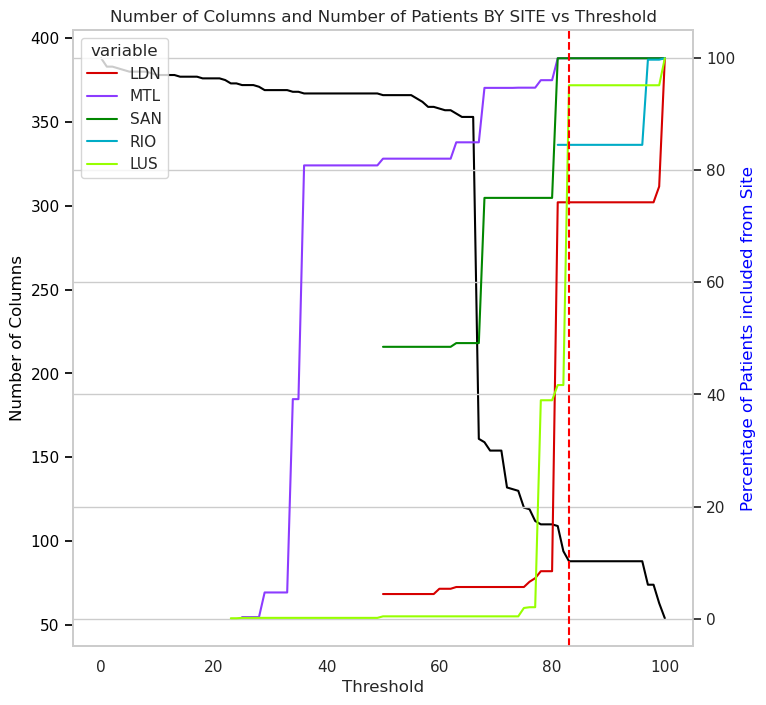

In [85]:
# Extract the data for plotting
x = dfThres["threshold"]
y1 = dfThres["nCols"]

lColSel = ["threshold", "LDN", "MTL", "SAN", "RIO", "LUS"]
palette = sns.color_palette(cc.glasbey, n_colors=5)
dfTmp = deepcopy(dfThres[lColSel])

# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot the first line plot
ax1.plot(x, y1, color="black", label="num of col")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Number of Columns", color="black")
ax1.tick_params("y", colors="black")
ax1.grid(False)

# Create a second y-axis and Plot the second line plot
ax2 = ax1.twinx()
sns.lineplot(
    x="threshold",
    y="value",
    hue="variable",
    data=pd.melt(dfTmp, ["threshold"]),
    palette=palette,
)

plt.axvline(x=83, color="r", linestyle="--")

# Add a title and legend
plt.title("Number of Columns and Number of Patients BY SITE vs Threshold")
ax2.set_ylabel("Percentage of Patients included from Site", color="blue")


# plt.legend(handles=[blue_patch, red_patch, green_patch])

# Display the plot
plt.savefig("OUTPUT/MP/02-splicing/2_1-thresholdsAll_sitePerc.png", dpi=600)
plt.show()

## Check all column thresholds for NORTH AMERICAN Sites

### Calculate DfThres

In [44]:
lThresNA = []
lLastCols = df.columns.to_list()
for i in range(0,101,1):
    threshold = len(dfNA)* (i/100)
    dfTmp = dfNA.dropna(thresh=threshold, axis=1).dropna()

    dThres = {
        "threshold": i,
        "nCols": len(dfTmp.columns),
        "nPatients": len(dfTmp),
        "colDroppedFromPrev": ",".join(
            list(set(lLastCols).difference(set(dfTmp.columns.to_list())))
        ),
        "cols": ",".join(dfTmp.columns.to_list()),
    }
    dThres.update(dfTmp["LC_STATUS"].value_counts().to_dict())
    dThres.update(
        add_suffix_to_dict_keys((dfTmp["LC_STATUS"].value_counts() / dfNA["LC_STATUS"].value_counts() * 100).to_dict(), '_Perc')
    )
    dThres.update(
        (
            dfTmp["dag"].replace(site_name_dict).value_counts(dropna=False)
            / dfNA["dag"].replace(site_name_dict).value_counts(dropna=False)
            * 100
        ).to_dict()
    )
    lThresNA.append(dThres)
dfThresNA = pd.DataFrame(lThresNA)

In [45]:
dfThresNA

,threshold,nCols,nPatients,colDroppedFromPrev,cols,HC_Perc,LC_NEG_Perc,LC_POS_Perc,LDN,MTL,SAN,LC_POS,LC_NEG,HC
0,0,388,0,,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,382,0,"CD-covid_test_result_5,CD-baby_covid,CD-outcom...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,382,0,"CD-covid_test_result_5,CD-baby_covid,CD-outcom...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,381,0,"CD-covid_test_result_5,CD-o2_saturation,CD-bab...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,381,0,"CD-covid_test_result_5,CD-o2_saturation,CD-bab...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,143,3450,"CD-myocarditis___4,CD-copd___4,CD-bacterial_vi...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,99.777382,93.774940,74.294671,99.965671,100.0,1175.0,2241.0,34.0
97,97,143,3450,"CD-myocarditis___4,CD-copd___4,CD-bacterial_vi...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,99.777382,93.774940,74.294671,99.965671,100.0,1175.0,2241.0,34.0
98,98,69,3451,"CD-myocarditis___4,CD-neurologic_complications...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,99.777382,93.854749,74.294671,100.000000,100.0,1176.0,2241.0,34.0
99,99,61,3477,"CD-myocarditis___4,CD-neurologic_complications...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,99.821906,95.849960,82.445141,100.000000,100.0,1201.0,2242.0,34.0


In [46]:
dfThres.to_csv('OUTPUT/MP/02-splicing/2_2-thresholdsNA.csv',index=False)

### Plot

#### Threshold VS nCol and nPatients

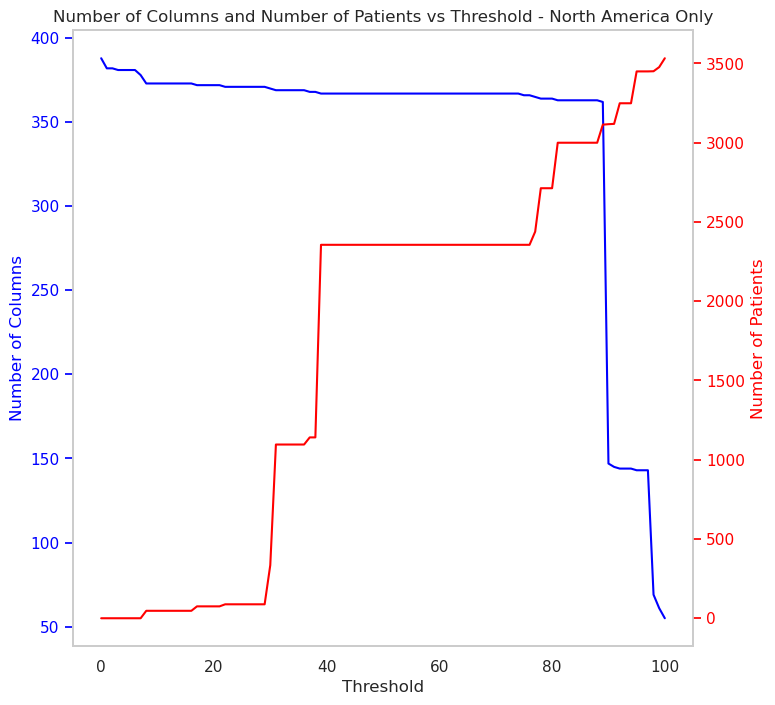

In [46]:
import matplotlib.pyplot as plt

# Extract the data for plotting
x = dfThresNA["threshold"]
y1 = dfThresNA["nCols"]
y2 = dfThresNA["nPatients"]


# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot the first line plot
ax1.plot(x, y1, color='blue')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of Columns', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second line plot
ax2.plot(x, y2, color='red')
ax2.set_ylabel('Number of Patients', color='red')
ax2.tick_params('y', colors='red')


ax1.grid(False)
ax2.grid(False)
# Add a title and legend
plt.title('Number of Columns and Number of Patients vs Threshold - North America Only')
# plt.legend(['Number of Columns', 'Number of Patients'])

# Display the plot
plt.savefig('OUTPUT/MP/02-splicing/2_2-thresholdsNA.png',dpi=600)
plt.show()

#### Threshold VS nCol and nPatients by LC group

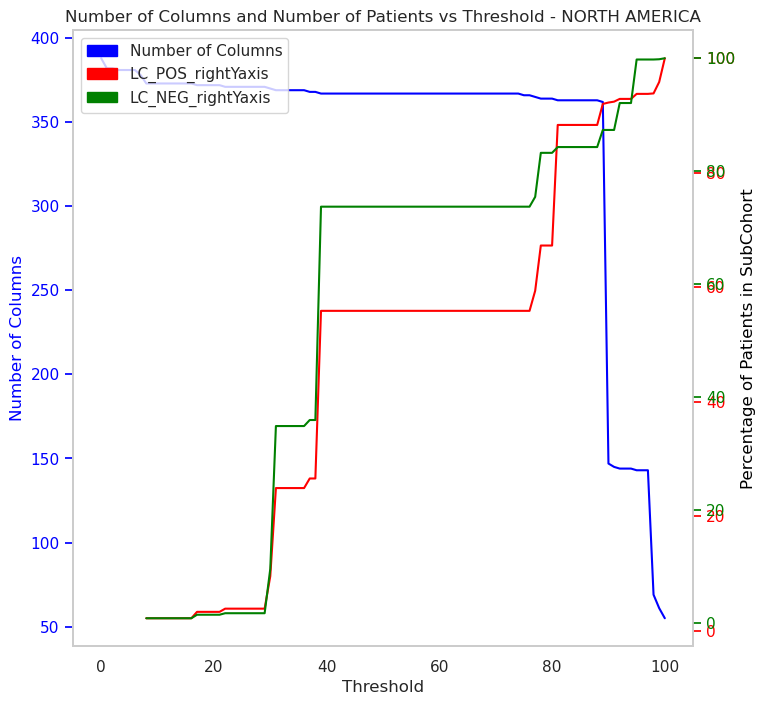

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Extract the data for plotting
x = dfThresNA["threshold"]
y1 = dfThresNA["nCols"]
y2 = dfThresNA["LC_POS_Perc"]
y3 = dfThresNA["LC_NEG_Perc"]

# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot the first line plot
ax1.plot(x, y1, color="blue", label="num of col")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Number of Columns", color="blue")
ax1.tick_params("y", colors="blue")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second line plot
ax2.plot(x, y2, color="red", label="LC_POS_rightYaxis")
ax2.set_ylabel("Percentage of Patients in SubCohort", color="black")
ax2.tick_params("y", colors="red")

# Create a third y-axis
ax3 = ax1.twinx()

# Plot the third line plot
ax3.plot(x, y3, color="green", label="LC_NEG_rightYaxis")
ax3.tick_params("y", colors="green")

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
# Add a title and legend
plt.title("Number of Columns and Number of Patients vs Threshold - NORTH AMERICA")

# Create a custom legend
blue_patch = mpatches.Patch(color="blue", label="Number of Columns")
red_patch = mpatches.Patch(color="red", label="LC_POS_rightYaxis")
green_patch = mpatches.Patch(color="green", label="LC_NEG_rightYaxis")
plt.legend(handles=[blue_patch, red_patch, green_patch])

# Display the plot
plt.savefig("OUTPUT/MP/02-splicing/2_1-thresholdsAll_subcohort.png", dpi=600)
plt.show()

#### Threshold VS patient site percentage

/tmp/ipykernel_13397/4239541759.py:21: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.lineplot(


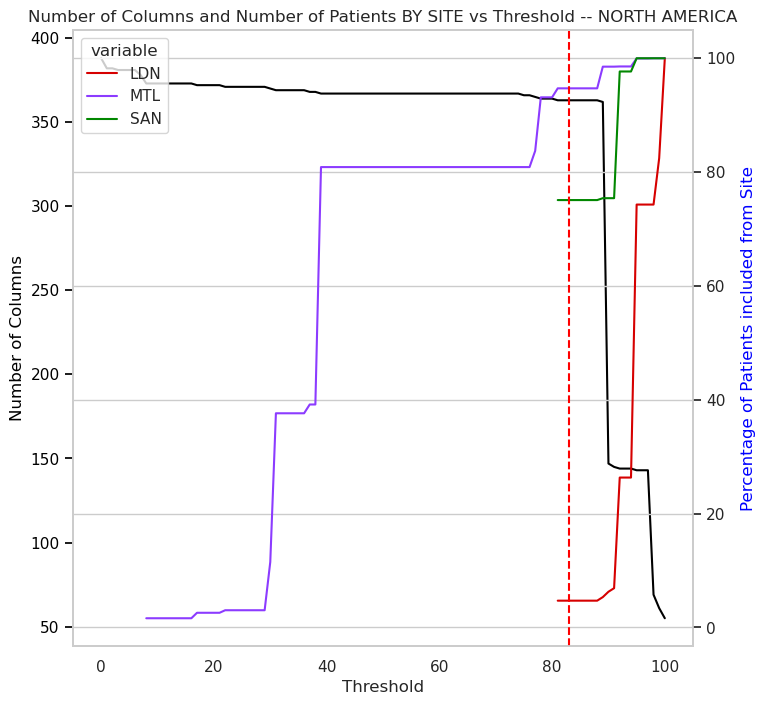

In [84]:

# Extract the data for plotting
x = dfThresNA["threshold"]
y1 = dfThresNA["nCols"]

lColSel = ["threshold", "LDN", "MTL", "SAN"]
palette = sns.color_palette(cc.glasbey, n_colors=5)
dfTmp = deepcopy(dfThresNA[lColSel])

# Create the figure and axes
fig, ax1 = plt.subplots()

# Plot the first line plot
ax1.plot(x, y1, color="black", label="num of col")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Number of Columns", color="black")
ax1.tick_params("y", colors="black")
ax1.grid(False)

# Create a second y-axis and Plot the second line plot
ax2 = ax1.twinx()
sns.lineplot(
    x="threshold",
    y="value",
    hue="variable",
    data=pd.melt(dfTmp, ["threshold"]),
    palette=palette,
)

plt.axvline(x=83, color="r", linestyle="--")

# Add a title and legend
plt.title("Number of Columns and Number of Patients BY SITE vs Threshold -- NORTH AMERICA")
ax2.set_ylabel("Percentage of Patients included from Site", color="blue")


# plt.legend(handles=[blue_patch, red_patch, green_patch])

# Display the plot
plt.savefig("OUTPUT/MP/02-splicing/2_2-thresholdsNA_sitePerc.png", dpi=600)
plt.show()

## Inspect Columns by Threshold to determine optimal Thresholds

In [79]:
# import data, only incld threshold that had some change from previous threshold
dfTAll = pd.read_csv("OUTPUT/MP/02-splicing/2_1-thresholdsAll.csv").dropna(
    subset=["colDropped"]
)
dfTNA = pd.read_csv("OUTPUT/MP/02-splicing/2_2-thresholdsNA.csv").dropna(
    subset=["colDropped"]
)

In [80]:
## -- RECOMMENDATION MP --
# based on the following, Threshold 36% is recommended bc we we see the biggest jump in terms fo number of patients included
dfTAll[ (dfTAll['threshold']>30) & (dfTAll['threshold']<60)]

,threshold,nCols,nPatients,colDropped,cols,HC_Perc,LC_NEG_Perc,LC_POS_Perc,LDN,LUS,MTL,RIO,SAN,LC_NEG,LC_POS,HC
34,34,368,1143,CD-temperature,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,24.846626,13.531085,NaN,0.135777,39.169241,NaN,NaN,810.0,333.0,NaN
36,36,367,2358,CD-pregnant,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",NaN,50.858896,28.443722,NaN,0.135777,80.878819,NaN,NaN,1658.0,700.0,NaN
50,50,366,2557,CD-severity_level,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",1.234568,51.472393,35.676554,4.388715,0.407332,82.080330,NaN,48.504983,1678.0,878.0,1.0
56,56,364,2557,"CD-ventilatory_support_type___2,CD-ventilatory...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",1.234568,51.472393,35.676554,4.388715,0.407332,82.080330,NaN,48.504983,1678.0,878.0,1.0
57,57,362,2557,"CD-medication_received___2,CD-type_of_care___1","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",1.234568,51.472393,35.676554,4.388715,0.407332,82.080330,NaN,48.504983,1678.0,878.0,1.0
58,58,359,2557,"CD-ventilatory_support_type___4,CD-ventilatory...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",1.234568,51.472393,35.676554,4.388715,0.407332,82.080330,NaN,48.504983,1678.0,878.0,1.0


In [81]:
## -- RECOMMENDATION MP -- 
# based on the following, Threshold 83% is recommended bc we are able to retain a majority of patients from each site to ensure as many samples from each site are included in the analysis
#retains 88 columns
#retains 5526 patients
#reatins >50% of patients per site
dfTAll[ (dfTAll['threshold']>75) & (dfTAll['threshold']<101)]


,threshold,nCols,nPatients,colDropped,cols,HC_Perc,LC_NEG_Perc,LC_POS_Perc,LDN,LUS,MTL,RIO,SAN,LC_NEG,LC_POS,HC
76,76,119,3037,CD-covid_test_result_1,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",1.234568,58.404908,45.997562,6.583072,2.036660,94.747683,NaN,75.083056,1904.0,1132.0,1.0
77,77,112,3039,"CD-respiratory_complications___4,CD-cardiovasc...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",1.234568,58.404908,46.078830,7.210031,2.036660,94.747683,NaN,75.083056,1904.0,1134.0,1.0
78,78,110,3626,"HHX-HIV or AIDS,VAX-vaccinated","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",1.234568,66.779141,58.837871,8.463950,38.968092,96.086509,NaN,75.083056,2177.0,1448.0,1.0
81,81,109,4738,CD-mode_of_diag,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.000000,76.656442,87.687932,74.294671,41.683639,100.000000,84.547739,100.000000,2499.0,2158.0,81.0
82,82,94,4738,"SYMPT-loss_of_appetite___2,SYMPT-muscle_aches_...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.000000,76.656442,87.687932,74.294671,41.683639,100.000000,84.547739,100.000000,2499.0,2158.0,81.0
83,83,88,5526,"SYMPT-fatigue___2,SYMPT-leg_swelling_edema___1...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.000000,94.294479,96.342950,74.294671,95.179905,100.000000,84.547739,100.000000,3074.0,2371.0,81.0
97,97,74,5647,"SYMPT-fatigue___1,SYMPT-extremity_weakness_or_...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.000000,98.006135,96.342950,74.294671,95.179905,100.000000,99.748744,100.000000,3195.0,2371.0,81.0
99,99,63,5656,"HHX-Arterial Hypertension,SYMPT-nausea_vomitin...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.000000,98.036810,96.668021,77.115987,95.179905,100.000000,99.748744,100.000000,3196.0,2379.0,81.0
100,100,54,5802,"sex,SYMPT-loss_of_taste_lost_of_smel___1,SYMPT...","dag,MED-Analgesics,MED-Anesthetics,MED-Antibac...",100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,3260.0,2461.0,81.0


In [128]:
## -- RECOMMENDATION MP -- 
# based on the following, Threshold 81 is also a good choice because it allows us to retain a decent chunk of the patients (w drop in LUS patients)
# but keep some more columns than 83
dfTAll[ (dfTAll['threshold']==81) | (dfTAll['threshold']==83)]


,threshold,nCols,nPatients,colDropped,cols,HC_Perc,LC_NEG_Perc,LC_POS_Perc,LDN,LUS,MTL,RIO,SAN,LC_NEG,LC_POS,HC
81,81,109,4738,CD-mode_of_diag,"sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,76.656442,87.687932,74.294671,41.683639,100.0,84.547739,100.0,2499.0,2158.0,81.0
83,83,88,5526,"SYMPT-fatigue___2,SYMPT-leg_swelling_edema___1...","sex,age,dag,MED-Analgesics,MED-Anesthetics,MED...",100.0,94.294479,96.342950,74.294671,95.179905,100.0,84.547739,100.0,3074.0,2371.0,81.0


In [121]:
# Export Dropped Columns From 81 83 Threshold Columns to File
# with open("OUTPUT/MP/02-splicing/2_1_colsThresAll_DroppedFrom81to83.txt", "w") as file:
#     s = (
#         dfTAll[dfTAll["threshold"] == 83]["colDropped"].iloc[0].split(",")
#         + dfTAll[dfTAll["threshold"] == 82]["colDropped"].iloc[0].split(',')
#     )
#     file.write("\n".join(s))

In [98]:
# Export Selected 83 Threshold Columns to File
cols83 = dfTAll[dfTAll['threshold']==83]['cols'].iloc[0].split(',')
# with open("OUTPUT/MP/02-splicing/2_1_colsThresAll_83.txt", "w") as file:
#     file.write('\n'.join(cols83))

In [131]:
# Export Selected 81 Threshold Columns to File
cols81 = dfTAll[dfTAll['threshold']==81]['cols'].iloc[0].split(',')
# with open("OUTPUT/MP/02-splicing/2_1_colsThresAll_81.txt", "w") as file:
#     file.write('\n'.join(cols81))

In [137]:
# Export dataFrame based on Threshold 83

# using the arrow dataset format is way faster than excel
# ~0.0s vs > 15s for the excel file

import datasets

# make a dataset
print(df[cols83].shape)
ds = datasets.arrow_dataset.Dataset.from_pandas(df[cols83].dropna())
ds.save_to_disk('../Data/DataV1/featuresThresAll83.arrow')

(5802, 88)


Saving the dataset (0/1 shards):   0%|          | 0/5526 [00:00<?, ? examples/s]

In [136]:
# Export dataFrame based on Threshold 83

# using the arrow dataset format is way faster than excel
# ~0.0s vs > 15s for the excel file

import datasets

# make a dataset
print(df[cols81].shape)
ds = datasets.arrow_dataset.Dataset.from_pandas(df[cols81].dropna())
ds.save_to_disk('../Data/DataV1/featuresThresAll81.arrow')

(5802, 109)


Saving the dataset (0/1 shards):   0%|          | 0/4738 [00:00<?, ? examples/s]

(5802, 109)